here processed the film height fields with a fixed time interval. according Fourier frequencies was obtained wave characteristics

### test1

In [217]:
def init_matplotlib(name, font_path=None, fig_size_mm=(140, 70), dpi=150, 
                   font_size=12, output_format='jpg'):
    import matplotlib.font_manager as font_manager
    """Initialization params matplotlib with customizible parameters
    Args:
        name: matplotlib module (plt)
        font_path: the path to the font file
        fig_size_mm: the size of the figure in mm (width, height)
        dpi: resolution
        font_size: базовый размер шрифта
        output_format: формат сохранения
    """
    #reset to default settings
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    #font settings with error handling
    if font_path is None:
        font_path = 'c:\\windows\\fonts\\times.ttf'
    try:
        prop = font_manager.FontProperties(fname=font_path)
        name.rcParams['font.family'] = prop.get_name()
    except (OSError, RuntimeError) as e:
        print(f"Warning: The {font_path} font could not be loaded. The default font is used. Error: {e}")
        name.rcParams['font.family'] = 'serif'
    #converting mm to inches
    fig_size_inch = (fig_size_mm[0] / 25.4, fig_size_mm[1] / 25.4)
    #grouping parameters for batch installation
    params = {
        #dimension and resolution
        "figure.figsize": fig_size_inch,
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "savefig.format": output_format,
        #fonts
        "font.size": font_size,
        "axes.titlesize": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        #lines and msrkers
        "lines.linewidth": 0.5,
        "lines.markersize": 3.0,
        "lines.markeredgewidth": 1.0,
        "markers.fillstyle": 'none',
        #legend
        "legend.numpoints": 1,
        "legend.columnspacing": 1.5,
        "legend.handlelength": 2.0,
        #axes
        "axes.formatter.limits": (-7, 7),
        "axes.formatter.use_locale": True
    }
    name.rcParams.update(params)

#an alternative version with context return
def matplotlib_context(**kwargs):
    """
    Сontext manager for temporary application of settings
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from contextlib import contextmanager
    @contextmanager
    def context():
        original_params = mpl.rcParams.copy()
        try:
            init_matplotlib(plt, **kwargs)
            yield plt
        finally:
            mpl.rcParams.update(original_params)
    
    return context()

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate

In [219]:
init_matplotlib(plt)

In [220]:
filepath = r'D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film_time_statistic.dat'
with open(filepath, 'r') as f:
    first_line = f.readline().strip() #1st strip
    #for structured mesh read width CV dx
    dxmesh = float(first_line)

In [221]:
data = pd.read_csv(filepath, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax*dxmesh
print(f"dxmesh = {dxmesh:.4g}")
print(f"NMax = {nmax:.4g}")
print(f"LMax = {lmax:.4g}")

dxmesh = 0.000153
NMax = 750
LMax = 0.1148


In [222]:
def N2X(n,dx):
    return n*dx
#choose points
n1 = 600
xp1 = N2X(n1,dxmesh)
n2 = 730
xp2 = N2X(n2,dxmesh)
print(f"delta21 = {xp2-xp1:.4g}")
name1 = "N" + str(n1)
name2 = "N" + str(n2)
tval = np.array(data["Time"])
delta1 = np.array(data[name1])
delta2 = np.array(data[name2])

delta21 = 0.01989


In [223]:
xp2 

0.11171189999999999

In [224]:
xp1

0.091818

In [225]:
patch2fileout = './/v2_figout_mesh1//timesignal_'
init_matplotlib(plt)

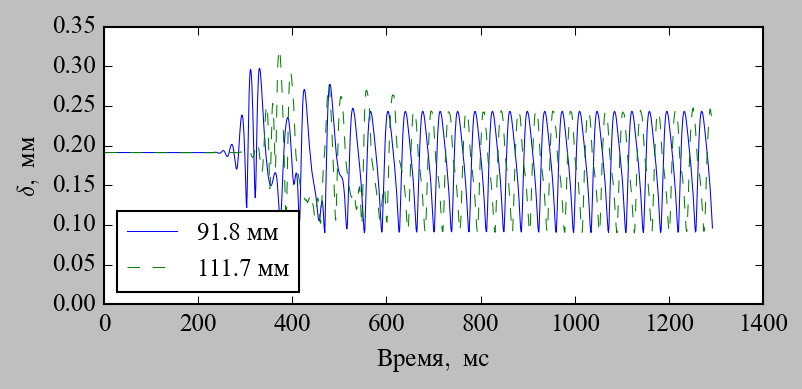

In [226]:
nameX = r'$\mathrm{Время,\ мс}$'
nameY = r'$\delta \mathrm{,\ мм}$'
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax1 = ax
ax1.plot(tval*1.0e3,delta1*1.0e3,'-b',label = f"{xp1*1000:.1f} мм")
ax1.plot(tval*1.0e3,delta2*1.0e3,'--g',label = f"{xp2*1000:.1f} мм")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.legend(loc='lower left')
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.savefig(patch2fileout, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [227]:
def freq_plot(sig, max_freq, fs):
    """
    Computes the amplitude spectrum of a signal using FFT
    Args:
        sig: input signal (1D array)
        max_freq: maximum frequency to display (Hz)
        fs: sampling frequency (Hz)
    
    Returns:
        f: frequency array [0, max_freq] (Hz)
        X: normalized amplitude spectrum
    """
    #сheck Nyquist criterion
    if max_freq > fs/2:
        raise ValueError(f'Max freq ({max_freq} Hz) must be <= Nyquist frequency ({fs/2} Hz)')
    N = len(sig)
    #сompute FFT and get amplitude spectrum
    X = np.abs(np.fft.fft(sig))
    #сreate frequency axis (two-sided spectrum)
    f = np.fft.fftfreq(N, 1/fs)
    #take only positive frequencies (one-sided spectrum)
    positive_freq = f >= 0
    f = f[positive_freq]
    X = X[positive_freq]
    #truncate to max_freq
    mask = f <= max_freq
    f = f[mask]
    X = X[mask]
    #normalization (multiply by 2 for all components except DC)
    X_norm = X / N * 2
    X_norm[0] = X_norm[0] / 2  #dc component should not be multiplied by 2
    return f, X_norm

In [228]:
def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    """
    Finds dominant wavelengths in thickness profile using spectral analysis
    Args:
        thickness: thickness profile data (1D array)
        dx: spatial sampling interval (e.g., in meters)
        top_n: number of top dominant wavelengths to return
        max_lambda: maximum wavelength to consider (optional filter)
    Returns:
        dominant_lambdas: top N dominant wavelengths
        dominant_amps: corresponding amplitudes for dominant wavelengths
        lambdas: all wavelengths in the spectrum
        X: all amplitude values in the spectrum
    """
    #calculate spatial sampling frequency (1/dx)
    fs = 1.0 / dx
    #compute amplitude spectrum using FFT
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    #convert to numpy arrays for safe indexing
    f = np.asarray(f)
    X = np.asarray(X)
    #remove zero frequency (DC component) and negative frequencies
    nonzero = f > 0
    f = f[nonzero]
    X = X[nonzero]
    #convert frequencies to wavelengths
    lambdas = 1.0 / f
    #filter out wavelengths longer than max_lambda if specified
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas = lambdas[mask]
        X = X[mask]
    #sort by amplitude in descending order and get top N indices
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    #extract dominant wavelengths and their amplitudes
    dominant_lambdas = lambdas[top_idx]
    dominant_freq = f[top_idx][0]
    dominant_amps = X[top_idx]
    return dominant_lambdas, dominant_amps, dominant_freq, lambdas, X

In [229]:
patch2fileout = './/v2_figout_mesh1//freq_'
init_matplotlib(plt)
tshift = 0.6

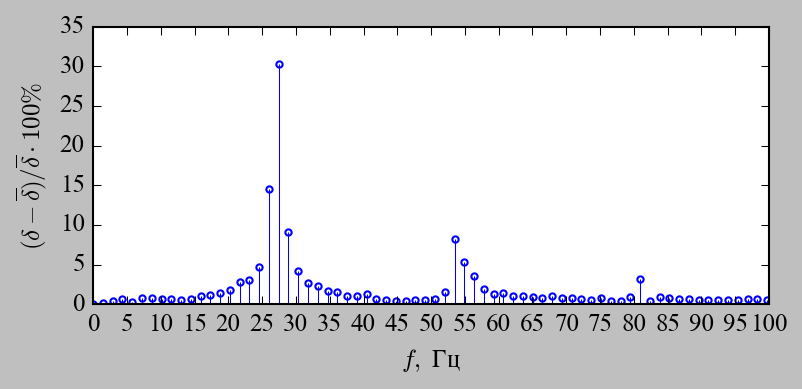

In [230]:
fig, ax = plt.subplots(nrows=1,ncols = 1)
nameX = r'$f \mathrm{,\ Гц}$'
nameY = r'$(\delta - \overline{\delta})/\overline{\delta} \cdot 100\%$'
fs = 1000
max_freq = 100
xmin, xmax, dx = 0.0, max_freq, 5.0
ymin, ymax, dy = 0.0, 25.0, 5.0
ax1 = ax
x1, y1 = tval[tval>=tshift], delta1[tval>=tshift]
X,Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax1.stem(X, Y)
ax1.set_xlim(xmin = xmin, xmax=xmax)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

In [231]:
i_maxFourier = np.argmax(Y)
f_maxFourier = X[i_maxFourier]
print(f'Maximum frequency from Fourier analysis {f_maxFourier}')
n_top = 5
top_indices = np.argsort(Y)[::-1]
top_frequencies = X[top_indices]
target_freqs = [53, 81]
for target in target_freqs:
    idx = np.argmin(np.abs(X - target))
    freq = X[idx]
    amp = Y[idx]
    print(f'Frequency near {target} Hz: {freq:.2f}')

Maximum frequency from Fourier analysis 27.456647398843927
Frequency near 53 Hz: 53.47
Frequency near 81 Hz: 80.92


In [232]:
top_indices

array([19, 18, 20, 37, 38, 17, 21, 39, 56, 16, 15, 22, 23, 40, 14, 24, 36,
       25, 42, 13, 41, 28, 12, 27, 44, 43, 11, 47, 26, 58, 55, 45, 48, 49,
       59, 46,  6,  5, 52, 10, 60, 35,  8,  7,  3, 50, 61, 67, 29, 68, 63,
       64, 51, 66, 34, 62, 69, 65, 33, 30,  9, 57,  2, 54, 31, 53, 32,  4,
        1,  0])

In [233]:
timelook = 1.0
#choose minimum delta time
idx = (data["Time"] - timelook).abs().idxmin()
#array of delta x between points
deltaxdistr = np.array(data.loc[idx])[1:]
#linespace
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

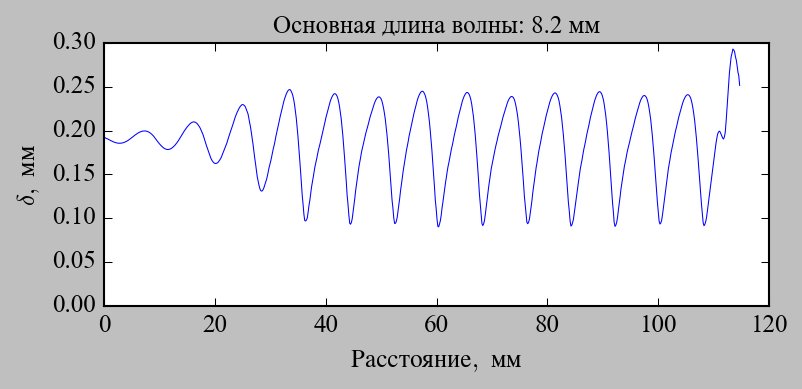

In [234]:
patch2fileout = './/v2_figout_mesh1//xsignal_'
init_matplotlib(plt)
fig, ax = plt.subplots(nrows=1,ncols = 1)
nameX = r'$\mathrm{Расстояние,\ мм}$'
nameY = r'$\delta,\ \mathrm{мм}$'
ax1 = ax
ax1.plot(xval*1.0e3,deltaxdistr*1.0e3,'-b',label = "-1")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

In [235]:
#filtering
y2 = delta2[tval>=tshift]
#correlation
corr = correlate(y1, y2, mode='full')
#lags
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
#shift time
time_shift = lag_max / fs
print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} s")
uw = abs(xp2-xp1)*1.0e3/abs(time_shift)
print(f"Фазовая скорость: {uw:.3g} mm/s")

Сдвиг между сигналами: -17 отсчётов, или -0.017000 s
Фазовая скорость: 1.17e+03 mm/s


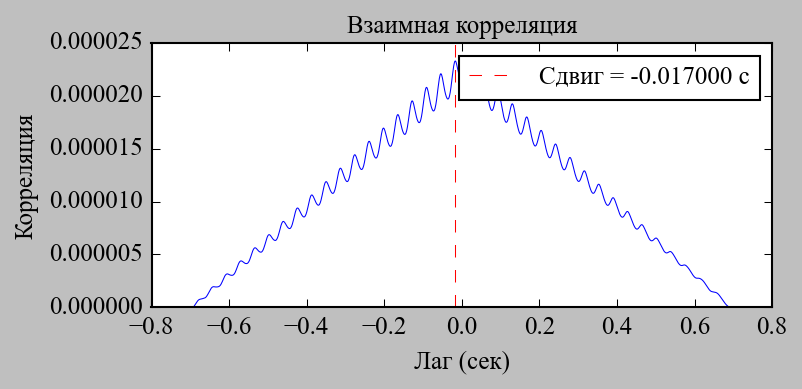

In [236]:
patch2fileout = './/v2_figout_mesh1//corr_'
fig, ax = plt.subplots(nrows=1, ncols=1)
ax1 = ax
ax1.plot(lags/fs, corr)
ax1.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} c")
ax1.set_xlabel("Лаг (сек)")
ax1.set_ylabel("Корреляция")
ax1.legend()
ax1.set_title("Взаимная корреляция")
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

have been obtained frequency and amplitude of the waves

In [237]:
print('Amplitude ',dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[1][0])

Amplitude  4.894376410820141e-05


In [238]:
print('Frequence ',dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[2])

Frequence  121.98043956522689


### test2

Now I see that the uw depends on the point signal. This means that it's useful to try a method with an "automatic" selection of values

Plan:\
The height of the film is known depending on the x coordinate on the last iteration
1. I tried to catch the first maximum amplitude of the quasi-stationary wave
2. Now I know the coordinates of the minimum and maximum. Then I can take the coordinates of the minimum or maximum. I have a file with the heights of the waves in time.  I could take these coordinates

In [239]:
#file_path_fx - path to file with f(x) dependence
file_path_fx = r'D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film__filmheight_712.dat'

In [240]:
#reading file
data_fx = pd.read_csv(file_path_fx, sep=r'\s+', skiprows=1, header=None, names=["x,m", "H,m"])

In [241]:
def find1(data):
    """
    Find maximun and minimum of f(x), apmlitudes (mean) on quasi-equilibrium
    """
    #maximun and minimum of f(x)
    dh = np.diff(data["H,m"])
    min_hi = np.where((dh[1:]>0) & (dh[:-1]<0))[0] + 1
    max_hi = np.where((dh[1:]<0) & (dh[:-1]>0))[0] + 1
    #catch quasi-equilibrium
    amplitudes = np.array(data["H,m"][max_hi]) - np.array(data["H,m"][min_hi])
    treshold_top = 0.1
    treshold_bot = 0.007
    da = np.diff(amplitudes)
    norm_da = np.abs(da)/np.abs(amplitudes)[:-1]
    quasi = np.where((norm_da<treshold_top) & (norm_da>treshold_bot))[0]
    #mean amlitude
    amp_mean = amplitudes.mean()
    return min_hi, max_hi, amplitudes, quasi, amp_mean

In [242]:
x_min, x_max, amplitudes, quasi, amp_mean = find1(data_fx)

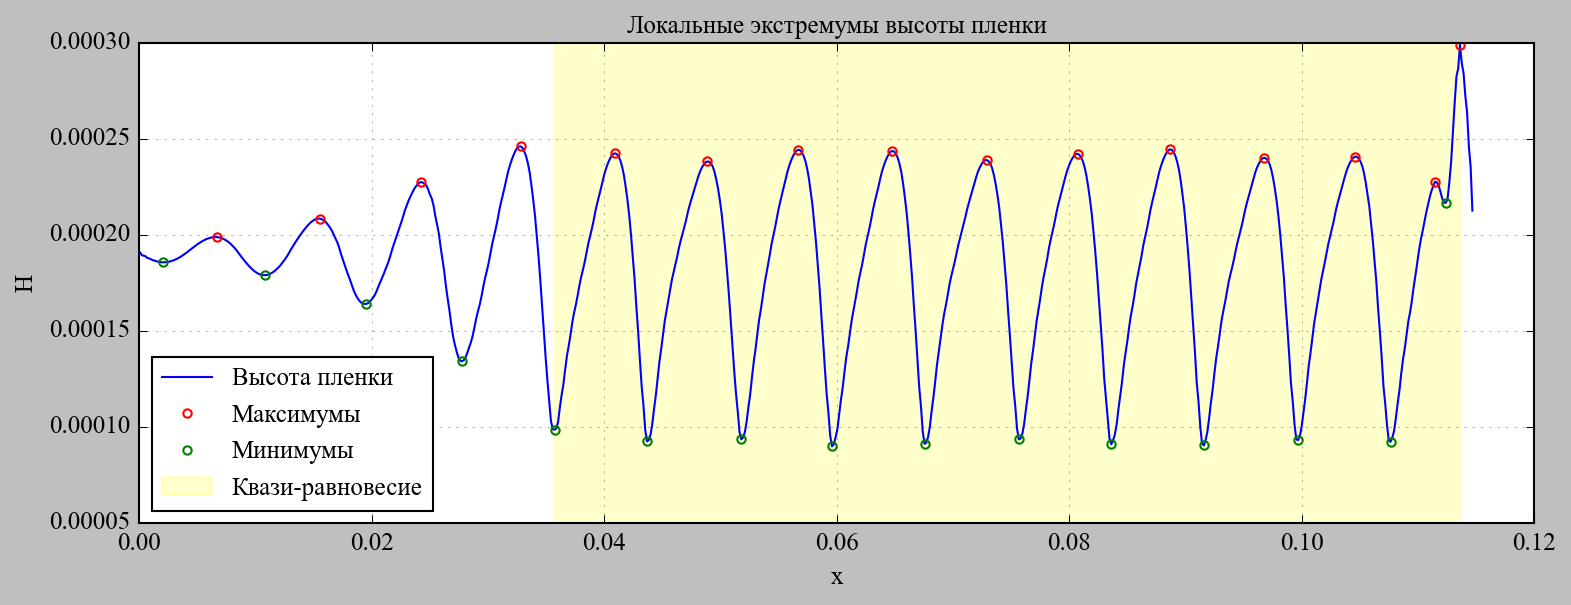

In [243]:
plt.figure(figsize=(12, 4))
plt.plot(data_fx["x,m"], data_fx["H,m"], 'b-', label='Высота пленки', linewidth=1)
plt.plot(data_fx["x,m"][x_max], data_fx["H,m"][x_max], 'ro', markersize=4, label='Максимумы')
plt.plot(data_fx["x,m"][x_min], data_fx["H,m"][x_min], 'go', markersize=4, label='Минимумы')
start_idx = quasi[0]
plt.axvspan(data_fx["x,m"][x_min[start_idx]], data_fx["x,m"][x_max[-1]], alpha=0.2, color='yellow', label='Квази-равновесие')
plt.xlabel('x')
plt.ylabel('H')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.title('Локальные экстремумы высоты пленки')
plt.show()

In [244]:
#file_path_ft - path to file with f(t) dependence
file_path_ft = r'D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film_time_statistic.dat'
with open(file_path_ft, 'r') as f:
    first_line = f.readline().strip() #1st strip
    #for structured mesh read width CV dx
    dxmesh = float(first_line)
data_ft = pd.read_csv(file_path_ft, sep=',', skiprows=1)

In [245]:
def find2(spatial_data, time_data, target_max_height, quasi_index=0):
    """
    Finds the time and sensor for the set maximum height value
    """
    print(f"Ищем высоту: {target_max_height:.6e}")
    min_hi, max_hi, amplitudes, quasi, amp_mean = find1(spatial_data)
    
    if len(quasi) == 0:
        print("Нет квази-равновесной области!")
        return [], target_max_height
    
    start_max_index = quasi[quasi_index]
    start_max_height = spatial_data["H,m"].iloc[max_hi[start_max_index]]
    print(f"Начинаем с максимума квази-равновесия [{quasi_index}]: {start_max_height:.6e}")

    results = []
    
    for col in time_data.columns:
        if col.startswith('N'):
            sensor_signal = time_data[col].values
            time_points = time_data["Time"].values
            #find the closest height to the maximum
            signal_diff = np.abs(sensor_signal - target_max_height)
            closest_signal_idx = np.argmin(signal_diff)
            closest_signal_value = sensor_signal[closest_signal_idx]
            closest_time = time_points[closest_signal_idx]
            difference = signal_diff[closest_signal_idx]
            
            if difference < 1e-8:
                results.append({
                    'sensor': col,
                    'time': closest_time,
                    'height': closest_signal_value,
                    'difference': difference
                })
    
    results.sort(key=lambda x: x['time'])
    print(f"Найдено совпадений: {len(results)}")
    if results:
        print(f"Первые 5 результатов:")
        for res in results[:5]:
            print(f"  {res['sensor']}: t={res['time']:.6e}, h={res['height']:.6e}, diff={res['difference']:.2e}")
    return results, target_max_height

In [246]:
min_hi, max_hi, amplitudes, quasi = find1(data_fx)[:4]
target_height = data_fx["H,m"].iloc[max_hi[0]]

print(f"Высота максимума для поиска: {target_height:.6e}")

results, found_height = find2(data_fx, data_ft, target_height, quasi[0])

Высота максимума для поиска: 1.990550e-04
Ищем высоту: 1.990550e-04
Начинаем с максимума квази-равновесия [4]: 2.424110e-04
Найдено совпадений: 167
Первые 5 результатов:
  N70: t=5.000000e-02, h=1.990600e-04, diff=5.00e-09
  N76: t=5.300000e-02, h=1.990600e-04, diff=5.00e-09
  N47: t=7.700000e-02, h=1.990600e-04, diff=5.00e-09
  N56: t=8.400000e-02, h=1.990600e-04, diff=5.00e-09
  N131: t=9.700000e-02, h=1.990600e-04, diff=5.00e-09


In [247]:
time_shift = results[0]['time'] 

In [248]:
def find_time_delays(time_data):
    """
    Finds the points in time when the values of the neighborhoods of points are equal
    """
    delays = []
    
    for i in range(1, 751):
        sensor_current = f"N{i}"
        sensor_next = f"N{i+1}"
        
        if sensor_current in time_data.columns and sensor_next in time_data.columns:
            signal_current = time_data[sensor_current].values
            signal_next = time_data[sensor_next].values
            time_points = time_data["Time"].values
            
            tolerance = 1e-8
            equal_indices = np.where(np.abs(signal_current - signal_next) < tolerance)[0]
            
            if len(equal_indices) > 0:
                first_equal_idx = equal_indices[0]
                equal_time = time_points[first_equal_idx]
                equal_value = signal_current[first_equal_idx]
                
                delays.append({
                    'sensors': f"{sensor_current}-{sensor_next}",
                    'time': equal_time,
                    'value': equal_value,
                    'sensor_pair': (i, i+1)
                })
    return delays

delays = find_time_delays(data_ft)
print(f"Найдено {len(delays)} пар датчиков с равными значениями:")
for delay in delays[:10]:
    print(f"{delay['sensors']}: t={delay['time']:.6e}, h={delay['value']:.6e}")

Найдено 749 пар датчиков с равными значениями:
N1-N2: t=3.899700e-01, h=1.898200e-04
N2-N3: t=1.060000e-01, h=1.885900e-04
N3-N4: t=8.000000e-03, h=1.940200e-04
N4-N5: t=2.449900e-01, h=1.889700e-04
N5-N6: t=9.629600e-04, h=1.912900e-04
N6-N7: t=9.629600e-04, h=1.912800e-04
N7-N8: t=9.629600e-04, h=1.912800e-04
N8-N9: t=9.629600e-04, h=1.912800e-04
N9-N10: t=9.629600e-04, h=1.912800e-04
N10-N11: t=9.629600e-04, h=1.912800e-04


In [249]:
unique_times, counts = np.unique([delay['time'] for delay in delays], return_counts=True)

print("Уникальные времена задержек и их частота:")
for time, count in zip(unique_times[:10], counts[:10]):
    print(f"  {time:.6e} с: {count} раз")

Уникальные времена задержек и их частота:
  9.629600e-04 с: 745 раз
  8.000000e-03 с: 1 раз
  1.060000e-01 с: 1 раз
  2.449900e-01 с: 1 раз
  3.899700e-01 с: 1 раз


In [250]:
final_time_delay = unique_times[0]
uw = (0.111477/750)/final_time_delay*100 # sm/c
uw

np.float64(15.43532441638282)

### test3

#### mesh1

Шаг сетки dxmesh = 0.000153 м
Количество точек NMax = 750
Длина области LMax = 0.1148 м
Расстояние между точками = 0.00153 м


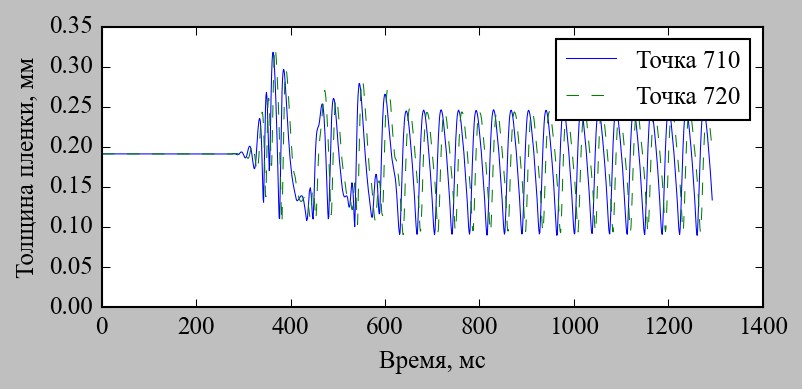

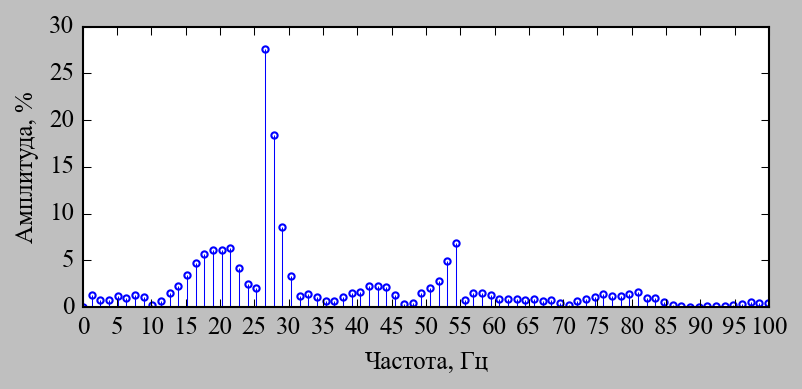

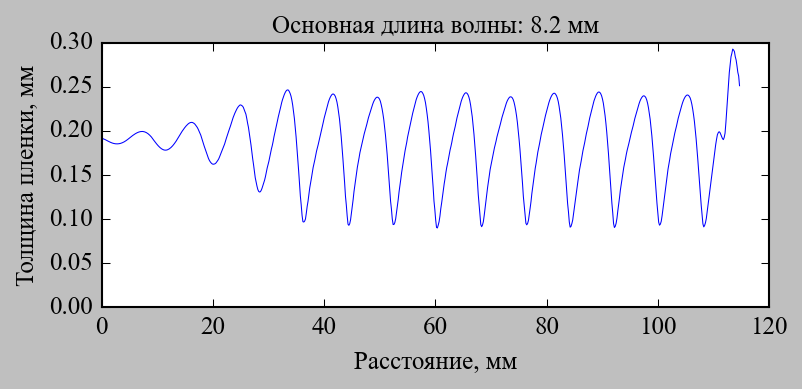

Сдвиг между сигналами: -7 отсчётов, или -0.007000 с
Фазовая скорость: 219 мм/с


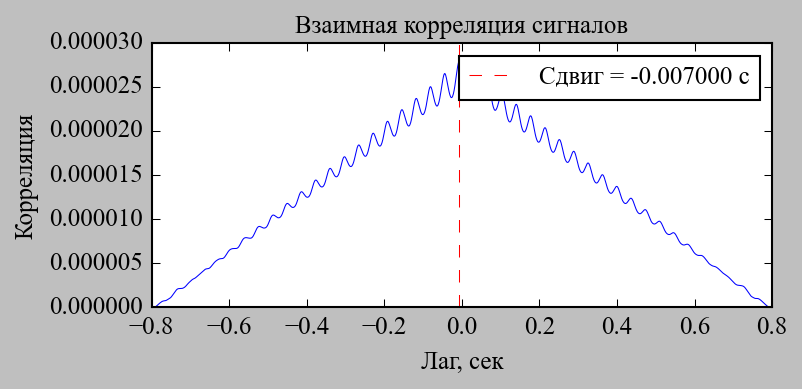

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

def init_matplotlib(name):
    import matplotlib.font_manager as font_manager
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    prop = font_manager.FontProperties(fname='c:\\windows\\fonts\\times.ttf')
    name.rcParams['font.family'] = prop.get_name()
    name.rcParams['lines.linewidth'] = 0.5
    name.rcParams["figure.figsize"] = (140.0/25.4,70.0/25.4)
    name.rcParams["figure.dpi"] = 150
    name.rcParams["savefig.dpi"] = plt.rcParams["figure.dpi"]
    name.rcParams["savefig.format"] = 'jpg'
    name.rcParams["font.size"] = 12
    name.rcParams["legend.fontsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.numpoints"] = 1
    name.rcParams["axes.titlesize"] = plt.rcParams["font.size"]
    name.rcParams["axes.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["xtick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["ytick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.columnspacing"] = 1.5
    name.rcParams["markers.fillstyle"] = 'none'
    name.rcParams["lines.markersize"] = 3.0
    name.rcParams["legend.handlelength"] = 2.0
    name.rcParams["lines.markeredgewidth"] = 1.0
    name.rcParams["axes.formatter.limits"] = (-7,7)
    name.rcParams["axes.formatter.use_locale"] = True

init_matplotlib(plt)

# Загрузка данных
filename = r"D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film_time_statistic.dat"
with open(filename, "r") as f:
    dxmesh = float(f.readline().strip())

data = pd.read_csv(filename, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax * dxmesh

print(f"Шаг сетки dxmesh = {dxmesh:.4g} м")
print(f"Количество точек NMax = {nmax:.4g}")
print(f"Длина области LMax = {lmax:.4g} м")

def N2X(n, dx):
    return n * dx

# Выбор точек для анализа
tshift = 0.5
n1, n2 = 710, 720
xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
print(f"Расстояние между точками = {xp2-xp1:.4g} м")

name1, name2 = "N" + str(n1), "N" + str(n2)
tval = np.array(data["Time"])
delta1, delta2 = np.array(data[name1]), np.array(data[name2])

# График временных сигналов
fig, ax = plt.subplots()
ax.plot(tval*1.0e3, delta1*1.0e3, '-b', label=f"Точка {n1}")
ax.plot(tval*1.0e3, delta2*1.0e3, '--g', label=f"Точка {n2}")
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Время, мс')
ax.set_ylabel('Толщина пленки, мм')
ax.legend()
plt.tight_layout()
plt.savefig('.//figout_v2//timesignal_mesh1')
plt.show()

# Спектральный анализ
def freq_plot(sig, max_freq, fs):
    if max_freq > fs/2:
        raise ValueError('Максимальная частота должна быть меньше частоты Найквиста')
    X = np.abs(np.fft.fft(sig))
    N = np.size(sig)
    f = np.arange(0.0, fs+fs/N, fs/N, dtype=float)
    num_bins = np.count_nonzero(f > max_freq)
    return f[0:num_bins], X[0:num_bins]/(N)*2

def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    fs = 1.0/dx
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    f, X = f[f > 0], X[f > 0]
    lambdas = 1.0 / f
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas, X = lambdas[mask], X[mask]
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    return lambdas[top_idx], X[top_idx], lambdas, X

# График спектра
fig, ax = plt.subplots()
fs, max_freq = 1000.0, 100.0
x1, y1 = tval[tval>=tshift], delta1[tval>=tshift]
X, Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax.stem(X, Y)
ax.set_xlim(0, max_freq)
ax.set_ylim(0)
ax.set_xlabel('Частота, Гц')
ax.set_ylabel('Амплитуда, %')
ax.set_xticks(np.arange(0, max_freq+5, 5))
plt.tight_layout()
plt.savefig('.//figout_v2//freq_mesh1')
plt.show()

# Пространственное распределение
timelook = 1.0
idx = (data["Time"] - timelook).abs().idxmin()
deltaxdistr = np.array(data.loc[idx])[1:]
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

fig, ax = plt.subplots()
ax.plot(xval*1.0e3, deltaxdistr*1.0e3, '-b')
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Расстояние, мм')
ax.set_ylabel('Толщина пленки, мм')
ax.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
plt.tight_layout()
plt.savefig('.//figout_v2//xsignal_mesh1')
plt.show()

# Корреляционный анализ
y2 = delta2[tval>=tshift]
corr = correlate(y1, y2, mode='full')
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
time_shift = lag_max / fs
uw = abs(xp2-xp1)*1.0e3/abs(time_shift)

print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} с")
print(f"Фазовая скорость: {uw:.3g} мм/с")

fig, ax = plt.subplots()
ax.plot(lags/fs, corr)
ax.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} с")
ax.set_xlabel("Лаг, сек")
ax.set_ylabel("Корреляция")
ax.legend()
ax.set_title("Взаимная корреляция сигналов")
plt.tight_layout()
plt.savefig('.//figout_v2//corr_mesh1')
plt.show()

Шаг сетки dxmesh = 0.000153 м
Количество точек NMax = 750
Длина области LMax = 0.1148 м
n1	 n2	 Расстояние, мм	 Время сдвига, мс	 Скорость, см/с	 Отклонение, %
Не найдено :( Ослабляем фильтры...

Пара точек :) n1=490, n2=500
Расстояние: 1.530 мм
Время сдвига: -7.0 мс
Расчетная скорость: 218.61 мм/с
Экспериментальная скорость: 21.7 см/с
Отклонение: 907.44%

Продолжение анализа с выбранными точками:
n1 = 490, x1 = 74.985 мм
n2 = 500, x2 = 76.515 мм


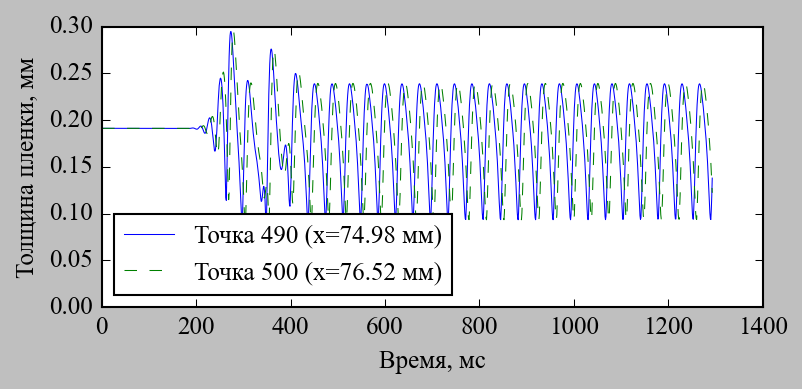

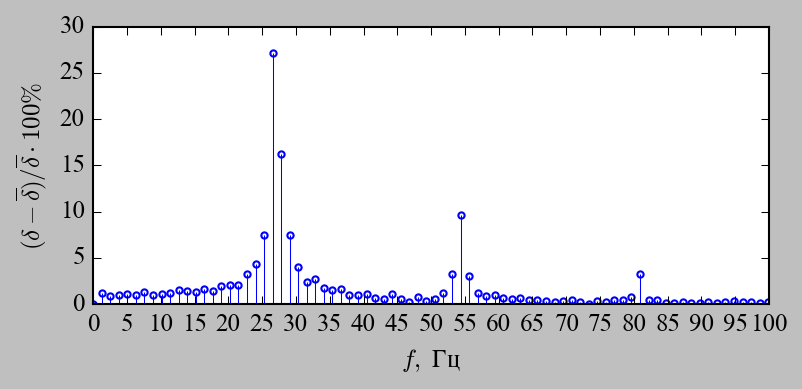

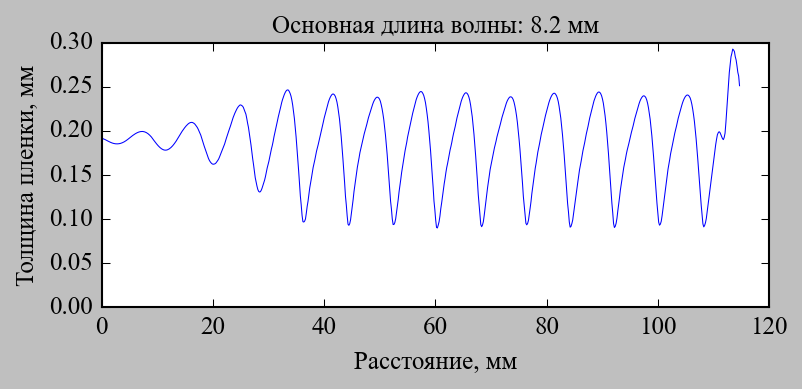

Сдвиг между сигналами: -7 отсчётов, или -0.007000 с


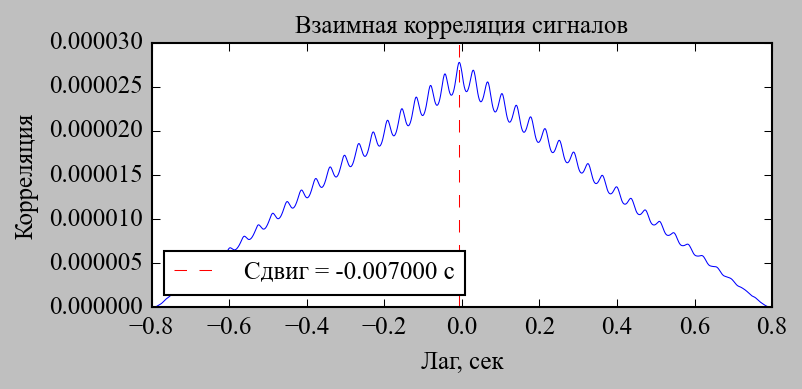

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

def init_matplotlib(name):
    import matplotlib.font_manager as font_manager
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    prop = font_manager.FontProperties(fname='c:\\windows\\fonts\\times.ttf')
    name.rcParams['font.family'] = prop.get_name()
    name.rcParams['lines.linewidth'] = 0.5
    name.rcParams["figure.figsize"] = (140.0/25.4,70.0/25.4)
    name.rcParams["figure.dpi"] = 150
    name.rcParams["savefig.dpi"] = plt.rcParams["figure.dpi"]
    name.rcParams["savefig.format"] = 'jpg'
    name.rcParams["font.size"] = 12
    name.rcParams["legend.fontsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.numpoints"] = 1
    name.rcParams["axes.titlesize"] = plt.rcParams["font.size"]
    name.rcParams["axes.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["xtick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["ytick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.columnspacing"] = 1.5
    name.rcParams["markers.fillstyle"] = 'none'
    name.rcParams["lines.markersize"] = 3.0
    name.rcParams["legend.handlelength"] = 2.0
    name.rcParams["lines.markeredgewidth"] = 1.0
    name.rcParams["axes.formatter.limits"] = (-7,7)
    name.rcParams["axes.formatter.use_locale"] = True

init_matplotlib(plt)

# Загрузка данных
filename = r"D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film_time_statistic.dat"
with open(filename, "r") as f:
    dxmesh = float(f.readline().strip())

data = pd.read_csv(filename, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax * dxmesh

print(f"Шаг сетки dxmesh = {dxmesh:.4g} м")
print(f"Количество точек NMax = {nmax:.4g}")
print(f"Длина области LMax = {lmax:.4g} м")

def N2X(n, dx):
    return n * dx

# Экспериментальное значение для сравнения
experimental_velocity = 21.7  # см/с
tshift = 0.5
fs = 1000.0

# Поиск лучшей пары точек
best_n1, best_n2 = 0, 0
best_velocity = 0
min_deviation = float('inf')

tval = np.array(data["Time"])

print("n1\t n2\t Расстояние, мм\t Время сдвига, мс\t Скорость, см/с\t Отклонение, %")

candidates = []

# Перебираем все возможные пары с дополнительными фильтрами
for n1 in range(1, nmax):
    for n2 in range(n1 + 10, nmax + 1, 5):  # Шаг 5 и минимальное расстояние 10 точек
        xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
        distance = abs(xp2 - xp1)
        
        # Фильтр 1: расстояние должно быть в разумных пределах (1-20 мм)
        if distance < 0.001 or distance > 0.02:  # 1-20 мм
            continue
            
        name1, name2 = "N" + str(n1), "N" + str(n2)
        delta1, delta2 = np.array(data[name1]), np.array(data[name2])
        
        y1 = delta1[tval >= tshift]
        y2 = delta2[tval >= tshift]
        
        if len(y1) < 100 or len(y2) < 100:  # Фильтр 2: достаточная длина сигнала
            continue
            
        corr = correlate(y1, y2, mode='full')
        lags = np.arange(-len(y1) + 1, len(y2))
        lag_max = lags[np.argmax(corr)]
        time_shift = lag_max / fs
        
        # Фильтр 3: время сдвига должно быть в разумных пределах (5-100 мс)
        if abs(time_shift) < 0.005 or abs(time_shift) > 0.1:
            continue
            
        velocity = distance * 1.0e3 / abs(time_shift)  # мм/с -> см/с
        
        # Фильтр 4: скорость должна быть в физически разумных пределах (10-50 см/с)
        if velocity < 10 or velocity > 50:
            continue
            
        deviation = abs(velocity - experimental_velocity) / experimental_velocity * 100
        
        # Сохраняем
        candidates.append((n1, n2, distance, time_shift, velocity, deviation))
        
        # Выводим
        if deviation < 20:
            print(f"{n1}\t {n2}\t {distance*1e3:.3f}\t\t {time_shift*1000:.1f}\t\t\t {velocity:.2f}\t\t {deviation:.2f}")

# Сортируемпо отклонению
if candidates:
    candidates.sort(key=lambda x: x[5])
    best_n1, best_n2, best_distance, best_time_shift, best_velocity, min_deviation = candidates[0]
    
    print(f"\n5 лучших кандидатов :)")
    for i, (n1, n2, dist, ts, vel, dev) in enumerate(candidates[:5]):
        print(f"{i+1}. n1={n1}, n2={n2}, расст.={dist*1000:.3f} мм, tсдвиг={ts*1000:.1f} мс, v={vel:.2f} см/с, откл.={dev:.2f}%")
else:
    print("Не найдено :( Ослабляем фильтры...")
    #Без фильтров
    for n1 in range(300, 500, 10):
        for n2 in range(500, 700, 10):
            xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
            distance = abs(xp2 - xp1)
            
            name1, name2 = "N" + str(n1), "N" + str(n2)
            delta1, delta2 = np.array(data[name1]), np.array(data[name2])
            
            y1 = delta1[tval >= tshift]
            y2 = delta2[tval >= tshift]
            
            if len(y1) == 0 or len(y2) == 0:
                continue
                
            corr = correlate(y1, y2, mode='full')
            lags = np.arange(-len(y1) + 1, len(y2))
            lag_max = lags[np.argmax(corr)]
            time_shift = lag_max / fs
            
            if time_shift == 0:
                continue
                
            velocity = distance * 1.0e3 / abs(time_shift)
            deviation = abs(velocity - experimental_velocity) / experimental_velocity * 100
            
            candidates.append((n1, n2, distance, time_shift, velocity, deviation))
    
    if candidates:
        candidates.sort(key=lambda x: x[5])
        best_n1, best_n2, best_distance, best_time_shift, best_velocity, min_deviation = candidates[0]

print(f"\nПара точек :) n1={best_n1}, n2={best_n2}")
print(f"Расстояние: {best_distance*1000:.3f} мм")
print(f"Время сдвига: {best_time_shift*1000:.1f} мс")
print(f"Расчетная скорость: {best_velocity:.2f} мм/с")
print(f"Экспериментальная скорость: {experimental_velocity} см/с")
print(f"Отклонение: {min_deviation:.2f}%")

# Присваиваем выбранные точки переменным n1 и n2
n1, n2 = best_n1, best_n2
xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
name1, name2 = "N" + str(n1), "N" + str(n2)
delta1, delta2 = np.array(data[name1]), np.array(data[name2])

# Дальнейший анализ с выбранными точками
y1 = delta1[tval >= tshift]
y2 = delta2[tval >= tshift]

print(f"\nПродолжение анализа с выбранными точками:")
print(f"n1 = {n1}, x1 = {xp1*1000:.3f} мм")
print(f"n2 = {n2}, x2 = {xp2*1000:.3f} мм")

# График временных сигналов
fig, ax = plt.subplots()
ax.plot(tval*1.0e3, delta1*1.0e3, '-b', label=f"Точка {n1} (x={xp1*1000:.2f} мм)")
ax.plot(tval*1.0e3, delta2*1.0e3, '--g', label=f"Точка {n2} (x={xp2*1000:.2f} мм)")
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Время, мс')
ax.set_ylabel('Толщина пленки, мм')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig('.//figout_v2//timesignal_best_mesh1')
plt.show()

# Спектральный анализ
def freq_plot(sig, max_freq, fs):
    if max_freq > fs/2:
        raise ValueError('Максимальная частота должна быть меньше частоты Найквиста')
    X = np.abs(np.fft.fft(sig))
    N = np.size(sig)
    f = np.arange(0.0, fs+fs/N, fs/N, dtype=float)
    num_bins = np.count_nonzero(f > max_freq)
    return f[0:num_bins], X[0:num_bins]/(N)*2

def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    fs = 1.0/dx
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    f, X = f[f > 0], X[f > 0]
    lambdas = 1.0 / f
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas, X = lambdas[mask], X[mask]
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    return lambdas[top_idx], X[top_idx], lambdas, X

# График спектра
nameX = r'$f \mathrm{,\ Гц}$'
nameY = r'$(\delta - \overline{\delta})/\overline{\delta} \cdot 100\%$'
fig, ax = plt.subplots()
fs, max_freq = 1000.0, 100.0
x1 = tval[tval>=tshift]
X, Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax.stem(X, Y)
ax.set_xlim(0, max_freq)
ax.set_ylim(0)
ax.set_xlabel(nameX)
ax.set_ylabel(nameY)
ax.set_xticks(np.arange(0, max_freq+5, 5))
plt.tight_layout()
plt.savefig('.//figout_v2//freq_best_mesh1')
plt.show()

# Пространственное распределение
timelook = 1.0
idx = (data["Time"] - timelook).abs().idxmin()
deltaxdistr = np.array(data.loc[idx])[1:]
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

fig, ax = plt.subplots()
ax.plot(xval*1.0e3, deltaxdistr*1.0e3, '-b')
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Расстояние, мм')
ax.set_ylabel('Толщина пленки, мм')
ax.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
plt.tight_layout()
plt.savefig('.//figout_v2//xsignal_best_mesh1')
plt.show()

# Корреляционный анализ
corr = correlate(y1, y2, mode='full')
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
time_shift = lag_max / fs

print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} с")

fig, ax = plt.subplots()
ax.plot(lags/fs, corr)
ax.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} с")
ax.set_xlabel("Лаг, сек")
ax.set_ylabel("Корреляция")
ax.legend(loc='lower left')
ax.set_title("Взаимная корреляция сигналов")
plt.tight_layout()
plt.savefig('.//figout_v2//corr_best_mesh1')
plt.show()

In [253]:
period = 4e-2
t, w = np.arange(0,1,1e-3), 2*np.pi/period
def func(t,w):
    return np.sin(w*t)

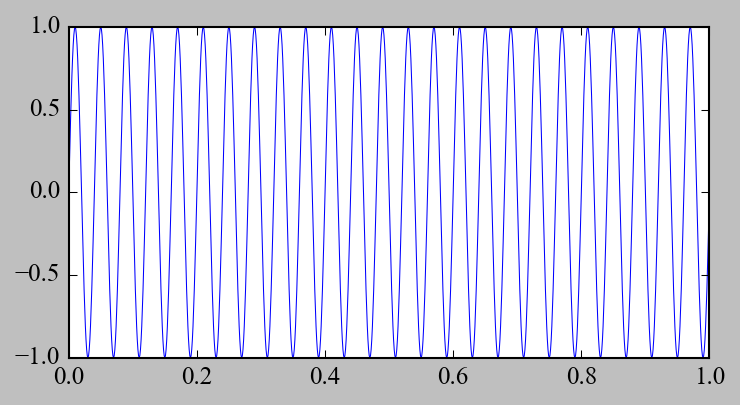

In [254]:
plt.plot(t,func(t,w))
plt.show()

In [255]:
data_train = pd.DataFrame(list(zip(t, func(t, w))), columns=['time','func'])

In [256]:
data_train

,time,func
0,0.000,0.000000
1,0.001,0.156434
2,0.002,0.309017
3,0.003,0.453990
4,0.004,0.587785
...,...,...
995,0.995,-0.707107
996,0.996,-0.587785
997,0.997,-0.453990
998,0.998,-0.309017


#### mesh2

Шаг сетки dxmesh = 7.651e-05 м
Количество точек NMax = 1500
Длина области LMax = 0.1148 м
Расстояние между точками = 0.00176 м


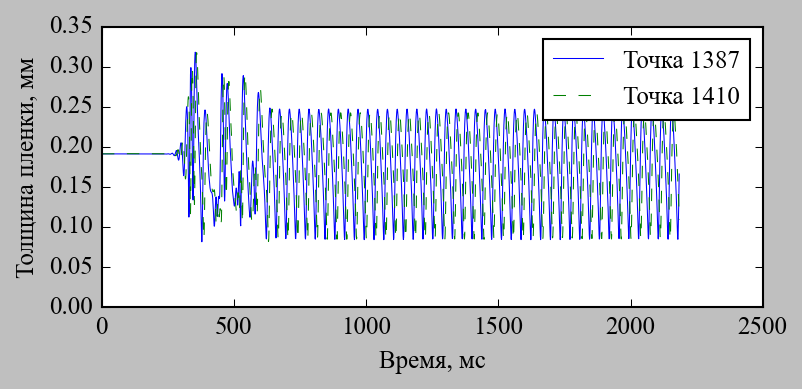

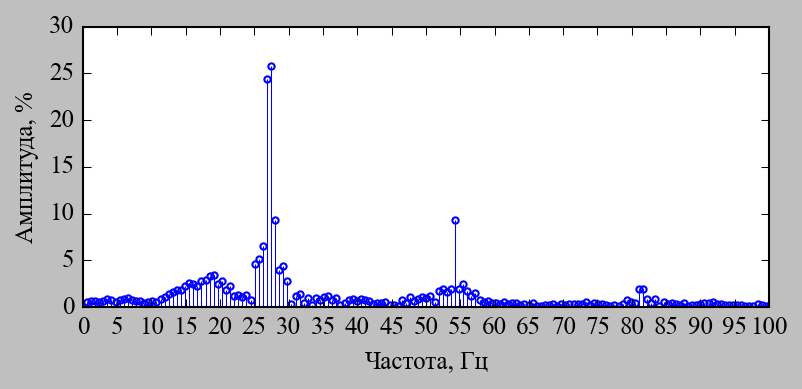

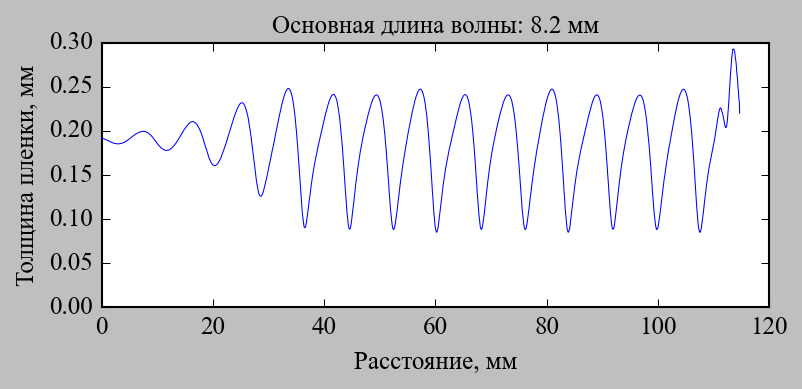

Сдвиг между сигналами: -8 отсчётов, или -0.008000 с
Фазовая скорость: 220 мм/с


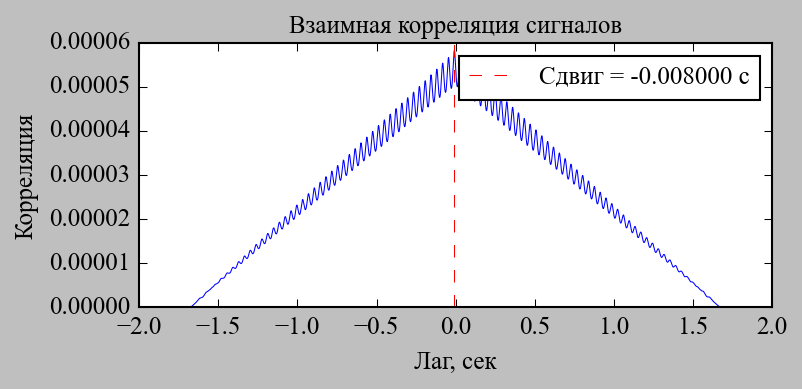

In [257]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

def init_matplotlib(name):
    import matplotlib.font_manager as font_manager
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    prop = font_manager.FontProperties(fname='c:\\windows\\fonts\\times.ttf')
    name.rcParams['font.family'] = prop.get_name()
    name.rcParams['lines.linewidth'] = 0.5
    name.rcParams["figure.figsize"] = (140.0/25.4,70.0/25.4)
    name.rcParams["figure.dpi"] = 150
    name.rcParams["savefig.dpi"] = plt.rcParams["figure.dpi"]
    name.rcParams["savefig.format"] = 'jpg'
    name.rcParams["font.size"] = 12
    name.rcParams["legend.fontsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.numpoints"] = 1
    name.rcParams["axes.titlesize"] = plt.rcParams["font.size"]
    name.rcParams["axes.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["xtick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["ytick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.columnspacing"] = 1.5
    name.rcParams["markers.fillstyle"] = 'none'
    name.rcParams["lines.markersize"] = 3.0
    name.rcParams["legend.handlelength"] = 2.0
    name.rcParams["lines.markeredgewidth"] = 1.0
    name.rcParams["axes.formatter.limits"] = (-7,7)
    name.rcParams["axes.formatter.use_locale"] = True

init_matplotlib(plt)

# Загрузка данных
filename = r"D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh2\VOFFilmFlow_1500_30\data\s2d_film_time_statistic.dat"
with open(filename, "r") as f:
    dxmesh = float(f.readline().strip())

data = pd.read_csv(filename, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax * dxmesh

print(f"Шаг сетки dxmesh = {dxmesh:.4g} м")
print(f"Количество точек NMax = {nmax:.4g}")
print(f"Длина области LMax = {lmax:.4g} м")

def N2X(n, dx):
    return n * dx

# Выбор точек для анализа
tshift = 0.5
n1, n2 = 1387, 1410
xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
print(f"Расстояние между точками = {xp2-xp1:.4g} м")

name1, name2 = "N" + str(n1), "N" + str(n2)
tval = np.array(data["Time"])
delta1, delta2 = np.array(data[name1]), np.array(data[name2])

# График временных сигналов
fig, ax = plt.subplots()
ax.plot(tval*1.0e3, delta1*1.0e3, '-b', label=f"Точка {n1}")
ax.plot(tval*1.0e3, delta2*1.0e3, '--g', label=f"Точка {n2}")
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Время, мс')
ax.set_ylabel('Толщина пленки, мм')
ax.legend()
plt.tight_layout()
plt.savefig('.//figout_v2//timesignal_mesh2')
plt.show()

# Спектральный анализ
def freq_plot(sig, max_freq, fs):
    if max_freq > fs/2:
        raise ValueError('Максимальная частота должна быть меньше частоты Найквиста')
    X = np.abs(np.fft.fft(sig))
    N = np.size(sig)
    f = np.arange(0.0, fs+fs/N, fs/N, dtype=float)
    num_bins = np.count_nonzero(f > max_freq)
    return f[0:num_bins], X[0:num_bins]/(N)*2

def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    fs = 1.0/dx
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    f, X = f[f > 0], X[f > 0]
    lambdas = 1.0 / f
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas, X = lambdas[mask], X[mask]
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    return lambdas[top_idx], X[top_idx], lambdas, X

# График спектра
fig, ax = plt.subplots()
fs, max_freq = 1000.0, 100.0
x1, y1 = tval[tval>=tshift], delta1[tval>=tshift]
X, Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax.stem(X, Y)
ax.set_xlim(0, max_freq)
ax.set_ylim(0)
ax.set_xlabel('Частота, Гц')
ax.set_ylabel('Амплитуда, %')
ax.set_xticks(np.arange(0, max_freq+5, 5))
plt.tight_layout()
plt.savefig('.//figout_v2//freq_mesh2')
plt.show()

# Пространственное распределение
timelook = 1.0
idx = (data["Time"] - timelook).abs().idxmin()
deltaxdistr = np.array(data.loc[idx])[1:]
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

fig, ax = plt.subplots()
ax.plot(xval*1.0e3, deltaxdistr*1.0e3, '-b')
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Расстояние, мм')
ax.set_ylabel('Толщина пленки, мм')
ax.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
plt.tight_layout()
plt.savefig('.//figout_v2//xsignal_mesh2')
plt.show()

# Корреляционный анализ
y2 = delta2[tval>=tshift]
corr = correlate(y1, y2, mode='full')
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
time_shift = lag_max / fs
uw = abs(xp2-xp1)*1.0e3/abs(time_shift)

print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} с")
print(f"Фазовая скорость: {uw:.3g} мм/с")

fig, ax = plt.subplots()
ax.plot(lags/fs, corr)
ax.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} с")
ax.set_xlabel("Лаг, сек")
ax.set_ylabel("Корреляция")
ax.legend()
ax.set_title("Взаимная корреляция сигналов")
plt.tight_layout()
plt.savefig('.//figout_v2//corr_mesh2')
plt.show()

Шаг сетки dxmesh = 7.651e-05 м
Количество точек NMax = 1500
Длина области LMax = 0.1148 м
n1	 n2	 Расстояние, мм	 Время сдвига, мс	 Скорость, см/с	 Отклонение, %
Не найдено :( Ослабляем фильтры...

Пара точек :) n1=460, n2=500
Расстояние: 3.061 мм
Время сдвига: -14.0 мс
Расчетная скорость: 218.61 мм/с
Экспериментальная скорость: 21.7 см/с
Отклонение: 907.41%

Продолжение анализа с выбранными точками:
n1 = 460, x1 = 35.196 мм
n2 = 500, x2 = 38.256 мм


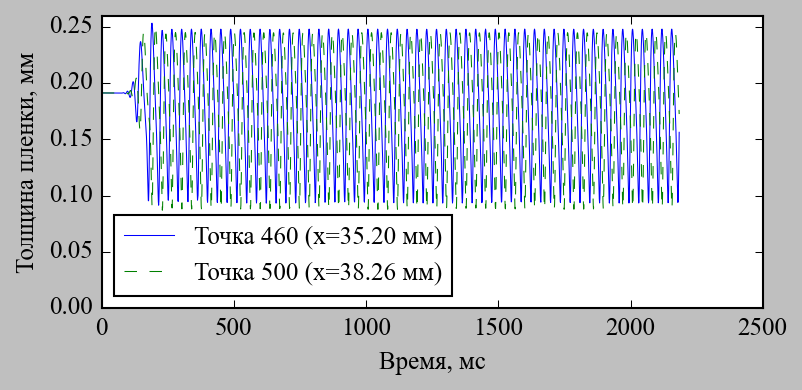

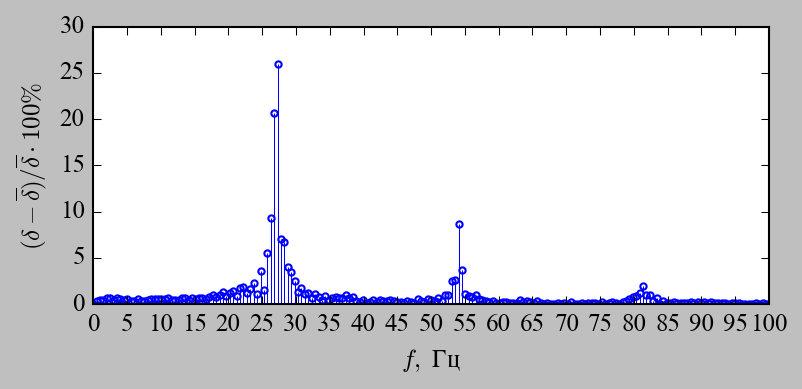

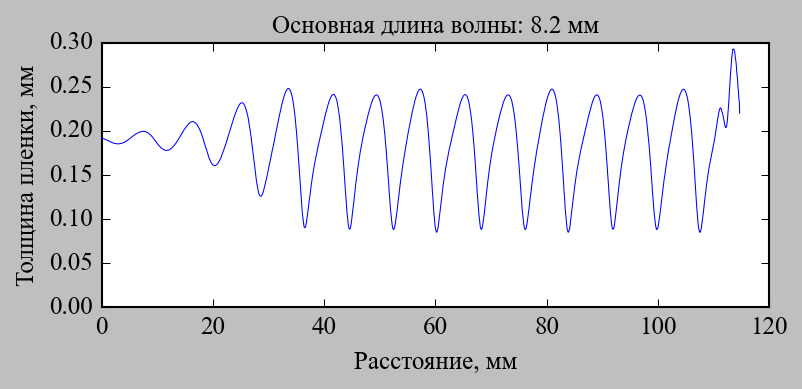

Сдвиг между сигналами: -14 отсчётов, или -0.014000 с


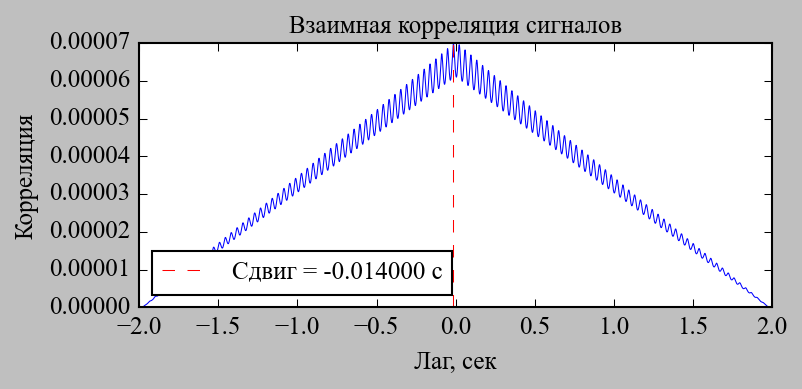

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

def init_matplotlib(name):
    import matplotlib.font_manager as font_manager
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    prop = font_manager.FontProperties(fname='c:\\windows\\fonts\\times.ttf')
    name.rcParams['font.family'] = prop.get_name()
    name.rcParams['lines.linewidth'] = 0.5
    name.rcParams["figure.figsize"] = (140.0/25.4,70.0/25.4)
    name.rcParams["figure.dpi"] = 150
    name.rcParams["savefig.dpi"] = plt.rcParams["figure.dpi"]
    name.rcParams["savefig.format"] = 'jpg'
    name.rcParams["font.size"] = 12
    name.rcParams["legend.fontsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.numpoints"] = 1
    name.rcParams["axes.titlesize"] = plt.rcParams["font.size"]
    name.rcParams["axes.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["xtick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["ytick.labelsize"] = plt.rcParams["font.size"]
    name.rcParams["legend.columnspacing"] = 1.5
    name.rcParams["markers.fillstyle"] = 'none'
    name.rcParams["lines.markersize"] = 3.0
    name.rcParams["legend.handlelength"] = 2.0
    name.rcParams["lines.markeredgewidth"] = 1.0
    name.rcParams["axes.formatter.limits"] = (-7,7)
    name.rcParams["axes.formatter.use_locale"] = True

init_matplotlib(plt)

# Загрузка данных
filename = r"D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh2\VOFFilmFlow_1500_30\data\s2d_film_time_statistic.dat"
with open(filename, "r") as f:
    dxmesh = float(f.readline().strip())

data = pd.read_csv(filename, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax * dxmesh

print(f"Шаг сетки dxmesh = {dxmesh:.4g} м")
print(f"Количество точек NMax = {nmax:.4g}")
print(f"Длина области LMax = {lmax:.4g} м")

def N2X(n, dx):
    return n * dx

# Экспериментальное значение для сравнения
experimental_velocity = 21.7  # см/с
tshift = 0.2
fs = 1000.0

# Поиск лучшей пары точек
best_n1, best_n2 = 0, 0
best_velocity = 0
min_deviation = float('inf')

tval = np.array(data["Time"])

print("n1\t n2\t Расстояние, мм\t Время сдвига, мс\t Скорость, см/с\t Отклонение, %")

candidates = []

# Перебираем все возможные пары с дополнительными фильтрами
for n1 in range(1, nmax):
    for n2 in range(n1 + 10, nmax + 1, 5):  # Шаг 5 и минимальное расстояние 10 точек
        xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
        distance = abs(xp2 - xp1)
        
        # Фильтр 1: расстояние должно быть в разумных пределах (1-20 мм)
        if distance < 0.001 or distance > 0.02:  # 1-20 мм
            continue
            
        name1, name2 = "N" + str(n1), "N" + str(n2)
        delta1, delta2 = np.array(data[name1]), np.array(data[name2])
        
        y1 = delta1[tval >= tshift]
        y2 = delta2[tval >= tshift]
        
        if len(y1) < 100 or len(y2) < 100:  # Фильтр 2: достаточная длина сигнала
            continue
            
        corr = correlate(y1, y2, mode='full')
        lags = np.arange(-len(y1) + 1, len(y2))
        lag_max = lags[np.argmax(corr)]
        time_shift = lag_max / fs
        
        # Фильтр 3: время сдвига должно быть в разумных пределах (5-100 мс)
        if abs(time_shift) < 0.005 or abs(time_shift) > 0.1:
            continue
            
        velocity = distance * 1.0e3 / abs(time_shift)  # мм/с -> см/с
        
        # Фильтр 4: скорость должна быть в физически разумных пределах (10-50 см/с)
        if velocity < 10 or velocity > 50:
            continue
            
        deviation = abs(velocity - experimental_velocity) / experimental_velocity * 100
        
        # Сохраняем
        candidates.append((n1, n2, distance, time_shift, velocity, deviation))
        
        # Выводим
        if deviation < 20:
            print(f"{n1}\t {n2}\t {distance*1e3:.3f}\t\t {time_shift*1000:.1f}\t\t\t {velocity:.2f}\t\t {deviation:.2f}")

# Сортируемпо отклонению
if candidates:
    candidates.sort(key=lambda x: x[5])
    best_n1, best_n2, best_distance, best_time_shift, best_velocity, min_deviation = candidates[0]
    
    print(f"\n5 лучших кандидатов :)")
    for i, (n1, n2, dist, ts, vel, dev) in enumerate(candidates[:5]):
        print(f"{i+1}. n1={n1}, n2={n2}, расст.={dist*1000:.3f} мм, tсдвиг={ts*1000:.1f} мс, v={vel:.2f} см/с, откл.={dev:.2f}%")
else:
    print("Не найдено :( Ослабляем фильтры...")
    #Без фильтров
    for n1 in range(300, 500, 10):
        for n2 in range(500, 700, 10):
            xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
            distance = abs(xp2 - xp1)
            
            name1, name2 = "N" + str(n1), "N" + str(n2)
            delta1, delta2 = np.array(data[name1]), np.array(data[name2])
            
            y1 = delta1[tval >= tshift]
            y2 = delta2[tval >= tshift]
            
            if len(y1) == 0 or len(y2) == 0:
                continue
                
            corr = correlate(y1, y2, mode='full')
            lags = np.arange(-len(y1) + 1, len(y2))
            lag_max = lags[np.argmax(corr)]
            time_shift = lag_max / fs
            
            if time_shift == 0:
                continue
                
            velocity = distance * 1.0e3 / abs(time_shift)
            deviation = abs(velocity - experimental_velocity) / experimental_velocity * 100
            
            candidates.append((n1, n2, distance, time_shift, velocity, deviation))
    
    if candidates:
        candidates.sort(key=lambda x: x[5])
        best_n1, best_n2, best_distance, best_time_shift, best_velocity, min_deviation = candidates[0]

print(f"\nПара точек :) n1={best_n1}, n2={best_n2}")
print(f"Расстояние: {best_distance*1000:.3f} мм")
print(f"Время сдвига: {best_time_shift*1000:.1f} мс")
print(f"Расчетная скорость: {best_velocity:.2f} мм/с")
print(f"Экспериментальная скорость: {experimental_velocity} см/с")
print(f"Отклонение: {min_deviation:.2f}%")

# Присваиваем выбранные точки переменным n1 и n2
n1, n2 = best_n1, best_n2
xp1, xp2 = N2X(n1, dxmesh), N2X(n2, dxmesh)
name1, name2 = "N" + str(n1), "N" + str(n2)
delta1, delta2 = np.array(data[name1]), np.array(data[name2])

# Дальнейший анализ с выбранными точками
y1 = delta1[tval >= tshift]
y2 = delta2[tval >= tshift]

print(f"\nПродолжение анализа с выбранными точками:")
print(f"n1 = {n1}, x1 = {xp1*1000:.3f} мм")
print(f"n2 = {n2}, x2 = {xp2*1000:.3f} мм")

# График временных сигналов
fig, ax = plt.subplots()
ax.plot(tval*1.0e3, delta1*1.0e3, '-b', label=f"Точка {n1} (x={xp1*1000:.2f} мм)")
ax.plot(tval*1.0e3, delta2*1.0e3, '--g', label=f"Точка {n2} (x={xp2*1000:.2f} мм)")
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Время, мс')
ax.set_ylabel('Толщина пленки, мм')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig('.//figout_v2//timesignal_best_mesh2')
plt.show()

# Спектральный анализ
def freq_plot(sig, max_freq, fs):
    if max_freq > fs/2:
        raise ValueError('Максимальная частота должна быть меньше частоты Найквиста')
    X = np.abs(np.fft.fft(sig))
    N = np.size(sig)
    f = np.arange(0.0, fs+fs/N, fs/N, dtype=float)
    num_bins = np.count_nonzero(f > max_freq)
    return f[0:num_bins], X[0:num_bins]/(N)*2

def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    fs = 1.0/dx
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    f, X = f[f > 0], X[f > 0]
    lambdas = 1.0 / f
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas, X = lambdas[mask], X[mask]
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    return lambdas[top_idx], X[top_idx], lambdas, X

# График спектра
nameX = r'$f \mathrm{,\ Гц}$'
nameY = r'$(\delta - \overline{\delta})/\overline{\delta} \cdot 100\%$'
fig, ax = plt.subplots()
fs, max_freq = 1000.0, 100.0
x1 = tval[tval>=tshift]
X, Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax.stem(X, Y)
ax.set_xlim(0, max_freq)
ax.set_ylim(0)
ax.set_xlabel(nameX)
ax.set_ylabel(nameY)
ax.set_xticks(np.arange(0, max_freq+5, 5))
plt.tight_layout()
plt.savefig('.//figout_v2//freq_best_mesh2')
plt.show()

# Пространственное распределение
timelook = 1.0
idx = (data["Time"] - timelook).abs().idxmin()
deltaxdistr = np.array(data.loc[idx])[1:]
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

fig, ax = plt.subplots()
ax.plot(xval*1.0e3, deltaxdistr*1.0e3, '-b')
ax.set_xlim(0.0)
ax.set_ylim(0.0)
ax.set_xlabel('Расстояние, мм')
ax.set_ylabel('Толщина пленки, мм')
ax.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
plt.tight_layout()
plt.savefig('.//figout_v2//xsignal_best_mesh2')
plt.show()

# Корреляционный анализ
corr = correlate(y1, y2, mode='full')
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
time_shift = lag_max / fs

print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} с")

fig, ax = plt.subplots()
ax.plot(lags/fs, corr)
ax.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} с")
ax.set_xlabel("Лаг, сек")
ax.set_ylabel("Корреляция")
ax.legend(loc='lower left')
ax.set_title("Взаимная корреляция сигналов")
plt.tight_layout()
plt.savefig('.//figout_v2//corr_best_mesh2')
plt.show()

#### mesh3